In [1]:
import pandas as pd
import numpy as np
import datetime as dt

Import Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Online Retail Data.csv', header=0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5.0,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1.0,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5.0,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1.0,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1.0,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
113938,505331,22550,HOLIDAY FUN LUDO,4.0,2010-04-21 12:36:00,3.75,17622.0
113939,505331,21888,BINGO SET,4.0,2010-04-21 12:36:00,3.75,17622.0
113940,505331,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-04-21 12:36:00,1.25,17622.0
113941,505331,22548,HEADS AND TAILS SPORTING FUN,12.0,2010-04-21 12:36:00,1.25,17622.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113943 entries, 0 to 113942
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      113943 non-null  object 
 1   product_code  113943 non-null  object 
 2   product_name  112886 non-null  object 
 3   quantity      113942 non-null  float64
 4   order_date    113942 non-null  object 
 5   price         113942 non-null  float64
 6   customer_id   87366 non-null   float64
dtypes: float64(3), object(4)
memory usage: 6.1+ MB


Data Cleansing

In [11]:
df_clean = df.copy()

# mengkonversi kolom order_date menjadi datetime
df_clean['order_date'] = df_clean['order_date'].astype('datetime64')
# membuat kolom year_month
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

In [13]:
# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()

In [15]:
# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]

In [ ]:
# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

In [ ]:
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()

In [21]:
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]

In [ ]:
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

In [25]:
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

In [27]:
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

In [29]:
# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,retro spots butter dish,1.0,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,retro spot mug,36.0,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12.0,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2.0,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2.0,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
86811,505331,21912,vintage snakes & ladders,4.0,2010-04-21 12:36:00,3.75,17622.0,2010-04,delivered,15.00
86812,505331,22550,holiday fun ludo,4.0,2010-04-21 12:36:00,3.75,17622.0,2010-04,delivered,15.00
86813,505331,21888,bingo set,4.0,2010-04-21 12:36:00,3.75,17622.0,2010-04,delivered,15.00
86814,505331,21791,vintage heads and tails card game,12.0,2010-04-21 12:36:00,1.25,17622.0,2010-04,delivered,15.00


In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86816 entries, 0 to 86815
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      86816 non-null  object        
 1   product_code  86816 non-null  object        
 2   product_name  86816 non-null  object        
 3   quantity      86816 non-null  float64       
 4   order_date    86816 non-null  datetime64[ns]
 5   price         86816 non-null  float64       
 6   customer_id   86816 non-null  object        
 7   year_month    86816 non-null  period[M]     
 8   order_status  86816 non-null  object        
 9   amount        86816 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5), period[M](1)
memory usage: 6.6+ MB


# User retention cohort

Agregat data transaksi ke bentuk summary total transaksi/order setiap pengguna setiap bulan

In [31]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12747.0,2010-02,3
3,12747.0,2010-03,2
4,12748.0,2010-01,6
...,...,...,...
3041,18272.0,2010-03,1
3042,18276.0,2010-04,1
3043,18283.0,2010-02,1
3044,18283.0,2010-03,2


Membuat kolom sebagai cohort dari pengguna, yaitu cohort bulan pertama kali bertransaksi

In [32]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12747.0,2010-02,3,2010-02
3,12747.0,2010-03,2,2010-02
4,12748.0,2010-01,6,2010-01
...,...,...,...,...
3041,18272.0,2010-03,1,2010-03
3042,18276.0,2010-04,1,2010-04
3043,18283.0,2010-02,1,2010-02
3044,18283.0,2010-03,2,2010-02


Menghitung jarak bulan antara setiap bulan transaksi dengan bulan pertama kali transaksi kemudian menjumlahkan dengan 1 agar jarak bulan 0 menjadi 1 yang berarti bulan pertama, dst.

In [33]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12747.0,2010-02,3,2010-02,1
3,12747.0,2010-03,2,2010-02,2
4,12748.0,2010-01,6,2010-01,1
...,...,...,...,...,...
3041,18272.0,2010-03,1,2010-03,1
3042,18276.0,2010-04,1,2010-04,1
3043,18283.0,2010-02,1,2010-02,1
3044,18283.0,2010-03,2,2010-02,2


Membuat tabel pivot dengan index berupa cohort, kolom berupa jarak bulan, dan nilainya adalah banyaknya pengguna unik (count unique dari ID pengguna)

In [34]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4
cohort,,,,
2010-01,714.0,281.0,335.0,208.0
2010-02,461.0,154.0,84.0,NaN
2010-03,528.0,83.0,NaN,NaN
2010-04,198.0,NaN,NaN,NaN


Menghitung banyaknya pengguna di masing-masing cohort (pengguna yang pertama kali transaksi di bulan tersebut) dan bagi semua nilai di tabel pivot dengan nilai tersebut (cohort) sebagai retention rate

In [35]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

cohort
2010-01    714.0
2010-02    461.0
2010-03    528.0
2010-04    198.0
Freq: M, Name: 1, dtype: float64

In [36]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4
cohort,,,,
2010-01,1.0,0.393557,0.469188,0.291317
2010-02,1.0,0.334056,0.182213,NaN
2010-03,1.0,0.157197,NaN,NaN
2010-04,1.0,NaN,NaN,NaN


Memvisualisasikan tabel pivot yang sudah berisi nilai retention rate tersebut dalam heatmap

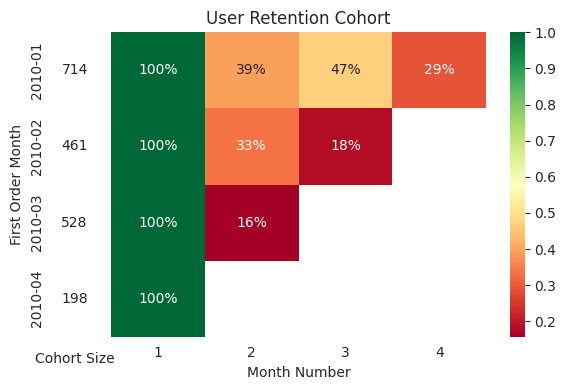

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()

Insight yang didapat :
1. Pengguna paling banyak bertransaksi pada Bulan pertama (Januari) sejumlah 714 Pengguna.
2. Pengguna paling banyak bertransaksi kembali pada Bulan ketiga (Maret) sejumlah 528 Pengguna.
3. Sebagian besar pengguna tidak bertransaksi kembali di setiap bulannya (dilihat dari retention rate dibawah 50%).
4. Pada bulan keempat, mengalami penurunan drastis.